In [1]:
%matplotlib inline
import os.path
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import network_sim as netsim
import iv_analysis as iv
from stats_util import get_medoid_ind

# deal with matplotlib bugs
def try_twice(fn):
    try:
        return fn()
    except np.linalg.LinAlgError:
        return fn()

## We want to simulate many networks with a relatively large number of variables, to test different ratios of observed to unobserved variables.

* 6 variables of interest
* observable ratios from 100 down to 5%

### Create parameter set

In [2]:
n_rois = 6
n_regions = np.linspace(n_rois, 20 * n_rois, 20, dtype=int)

n_trials = 2000
n_time = 500

iv_prob = 0.025
iv_gain = 0.1
# snr = 1.
snr = None  # actually don't control snr b/c this is like an O(n^5) operation the way I have it implemented
spt = 5

### Do trials for each set of parameters

For each trial, analyze connectivity using all methods and degrees of observability, and get the correlations with actual connectivity among the regions of interest.

In [3]:
def seeded_sim_network(regions, seed: np.uint32=None):
    """Simulate network with specific rng seed"""
    
    if seed is not None:
        assert np.isscalar(seed), 'Seed must be a scalar'
        np.random.seed(seed)
    
    con_mat = netsim.gen_con_mat(regions, max_eig=0.75, net_type='smallworld')
    log_acts, ivs, con_mat = netsim.sim_network(
        con_mat=con_mat,
        n_time=n_time,
        iv_prob=iv_prob,
        iv_gain=iv_gain,
        snr=snr,
        steps_per_time=spt
    )
    
    return log_acts, ivs, np.linalg.matrix_power(con_mat, spt)

res_file = '../data_sim/est_corr_sparse.npz'

if not os.path.exists(res_file):
        
    seeds = np.random.randint(0, 2 ** 32, dtype=np.uint32, size=(n_trials, len(n_regions)))
    estimate_rs = {key: np.ndarray((n_trials, len(n_regions))) for key in iv.methods}
        
    for i in range(n_trials):
        for j, n_reg in enumerate(n_regions):
        
            # generate network and simulate
            log_acts, ivs, con_mat = seeded_sim_network(n_reg, seeds[i, j])        
                
            con_mat_roi = con_mat[np.ix_(range(n_rois), range(n_rois))]                
            estimates = iv.all_methods_estimate(log_acts, ivs, observable=range(n_rois), rois=range(n_rois))          

            for key in iv.methods:
                estimate_rs[key][i, j] = stats.pearsonr(con_mat_roi.flatten(), estimates[key].flatten())[0]

    np.savez(res_file, seeds=seeds, estimate_rs=estimate_rs)

### Find a single network that is the medoid across methods in average accuracy

In [4]:
medoids = np.ndarray((len(n_regions),), dtype=int)

with np.load(res_file, allow_pickle=True) as sim_data:
    for i, n_reg in enumerate(n_regions):
        rs = np.ndarray((n_trials, len(iv.methods)))
        
        for j, est in enumerate(sim_data['estimate_rs'].item().values()):            
            
            rs[:, j] = est[:, i]
            
        medoids[i] = get_medoid_ind(rs)

### Plot medoid accuracy (correlation)

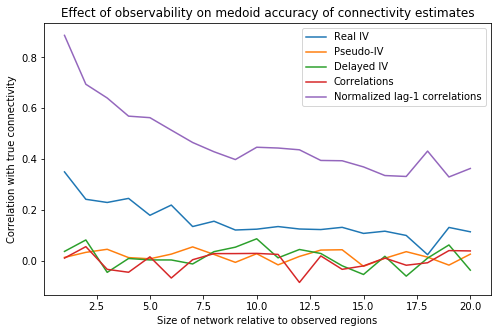

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

with np.load(res_file, allow_pickle=True) as sim_data:
    for key, method in iv.methods.items():
        ax.plot(n_regions / n_rois, sim_data['estimate_rs'].item()[key][medoids, range(len(n_regions))], label=method['name'])
    
ax.set_title('Effect of observability on medoid accuracy of connectivity estimates')
ax.set_xlabel('Size of network relative to observed regions')
ax.set_ylabel('Correlation with true connectivity')

box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='upper right')
plt.show()